<a href="https://colab.research.google.com/github/praffuln/agentic-ai/blob/master/memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print('helloworld')

helloworld


# Lesson 2: Baseline Email Assistant

This lesson builds an email assistant that:
- Classifies incoming messages (respond, ignore, notify)
- Drafts responses
- Schedules meetings

We'll start with a simple implementation - one that uses hard-coded rules to handle emails.

![Memory Course App](./img/memory_course_email.png)


### Setup Environments


In [ ]:
!pip install google-generativeai tiktoken chromadb langgraph langchain langchain_community langchainhub ipykernel langchain_groq sentence_transformers boto3 langchain_aws docx exceptions langchain_openai langchain-google-vertexai
!pip install -U langchain-google-vertexai
!pip install --upgrade python-docx


 ## Setup Keys For GOOGLE_API_KEY


In [3]:

 # Assigning value to variable
GEMINI_API_KEY=''
SERPER_API_KEY = ''
GROQ_API_KEY = ''


# setup environments


In [4]:
import os
os.environ['SERPER_API_KEY'] = SERPER_API_KEY
os.environ['GEMINI_API_KEY'] = GEMINI_API_KEY
os.environ['GROQ_API_KEY'] = GROQ_API_KEY



## setup LLM

In [5]:
import google.generativeai as genai
genai.configure(api_key=GEMINI_API_KEY)
llm = genai.GenerativeModel("gemini-1.5-flash")
response = llm.generate_content("Explain how AI works")
print(response.text)




AI, or Artificial Intelligence, encompasses a broad range of techniques designed to enable computers to mimic human intelligence.  There's no single "how it works," but rather a collection of approaches, each with its own strengths and weaknesses.  Here's a breakdown of some key concepts:

**1. Machine Learning (ML):**  This is arguably the most prominent approach to AI.  Instead of explicitly programming a computer with instructions for every possible scenario, ML algorithms learn from data.  They identify patterns, make predictions, and improve their performance over time without being explicitly programmed for each task.

* **Supervised Learning:** The algorithm is trained on a labeled dataset – data where the input and desired output are provided.  For example, showing the algorithm thousands of pictures of cats and dogs, labeled accordingly, allows it to learn to distinguish between them.
* **Unsupervised Learning:** The algorithm learns from unlabeled data, identifying patterns a

## Setup a Profile, Prompt and Example Email

In [6]:
profile = {
    "name": "John",
    "full_name": "John Doe",
    "user_profile_background": "Senior software engineer leading a team of 5 developers",
}

In [7]:
prompt_instructions = {
    "triage_rules": {
        "ignore": "Marketing newsletters, spam emails, mass company announcements",
        "notify": "Team member out sick, build system notifications, project status updates",
        "respond": "Direct questions from team members, meeting requests, critical bug reports",
    },
    "agent_instructions": "Use these tools when appropriate to help manage John's tasks efficiently."
}

In [8]:
# Example incoming email
email = {
    "from": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "body": """
Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

## Define the first part of the agent - triage.

In [9]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated
from langchain.chat_models import init_chat_model

In [10]:
!pip install langchain_google_genai -U
from langchain_google_genai import GoogleGenerativeAI
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.output_parsers import PydanticOutputParser # Import PydanticOutputParser


class Router(BaseModel):
    """Analyze the unread email and route it according to its content."""

    reasoning: str = Field(
        description="Step-by-step reasoning behind the classification."
    )
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore' for irrelevant emails, "
        "'notify' for important information that doesn't need a response, "
        "'respond' for emails that need a reply",
    )

# Wrap the Google Generative AI model with LangChain's wrapper
# Use `model` instead of `model_name` to specify the model
llm = genai.GenerativeModel("gemini-1.5-flash") # This line is replaced


# Define the prompt template
prompt_template = """Analyze the unread email and route it according to its content.
Email: {email}
Triage Rules:
- Ignore: "{ignore}"
- Notify: {notify}
- Respond: {respond}

Reasoning:
"""  # The model will complete this with its reasoning

# Create a PydanticOutputParser instance
output_parser = PydanticOutputParser(pydantic_object=Router) # Create an instance of PydanticOutputParser

# Create an LLMChain for structured output
# llm_router = LLMChain(
#     llm=llm,
#     prompt=PromptTemplate.from_template(prompt_template),
#     output_parser=output_parser  # Pass the PydanticOutputParser instance
# )


In [11]:
# Agent prompt baseline
agent_system_prompt = """
< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage {name}'s communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
</ Tools >

< Instructions >
{instructions}
</ Instructions >
"""

# Agent prompt semantic memory
agent_system_prompt_memory = """
< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage {name}'s communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
4. manage_memory("email_assistant", user, "collection") - Store any relevant information about contacts, actions, discussion, etc. in memory for future reference
5. manage_memory("email_assistant", user, "user_profile") - Store any relevant information about the recipient, {name}, in the user profile for future reference the current user profile is shown below
6. search_memory("email_assistant", user, "collection") - Search memory for detail from previous emails
7. manage_memory("email_assistant", user, "instructions") - Update the instructions for agent tool usage based upon the user feedback
</ Tools >

< User profile >
{profile}
</ User profile >

< Instructions >
{instructions}
</ Instructions >
"""

# Triage prompt
triage_system_prompt = """
< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Background >
{user_profile_background}.
</ Background >

< Instructions >

{name} gets lots of emails. Your job is to categorize each email into one of three categories:

1. IGNORE - Emails that are not worth responding to or tracking
2. NOTIFY - Important information that {name} should know about but doesn't require a response
3. RESPOND - Emails that need a direct response from {name}

Classify the below email into one of these categories. also print the reasoning.

</ Instructions >

< Rules >
Emails that are not worth responding to:
{triage_no}

There are also other things that {name} should know about, but don't require an email response. For these, you should notify {name} (using the `notify` response). Examples of this include:
{triage_notify}

Emails that are worth responding to:
{triage_email}
</ Rules >

< Few shot examples >
{examples}
</ Few shot examples >
"""

triage_user_prompt = """
Please determine how to handle the below email thread:

From: {author}
To: {to}
Subject: {subject}
{email_thread}"""


In [12]:
system_prompt = triage_system_prompt.format(
    full_name=profile["full_name"],
    name=profile["name"],
    examples=None,
    user_profile_background=profile["user_profile_background"],
    triage_no=prompt_instructions["triage_rules"]["ignore"],
    triage_notify=prompt_instructions["triage_rules"]["notify"],
    triage_email=prompt_instructions["triage_rules"]["respond"],
)

In [13]:
user_prompt = triage_user_prompt.format(
    author=email["from"],
    to=email["to"],
    subject=email["subject"],
    email_thread=email["body"],
)

In [14]:
print(system_prompt)


< Role >
You are John Doe's executive assistant. You are a top-notch executive assistant who cares about John performing as well as possible.
</ Role >

< Background >
Senior software engineer leading a team of 5 developers. 
</ Background >

< Instructions >

John gets lots of emails. Your job is to categorize each email into one of three categories:

1. IGNORE - Emails that are not worth responding to or tracking
2. NOTIFY - Important information that John should know about but doesn't require a response
3. RESPOND - Emails that need a direct response from John

Classify the below email into one of these categories. also print the reasoning.

</ Instructions >

< Rules >
Emails that are not worth responding to:
Marketing newsletters, spam emails, mass company announcements

There are also other things that John should know about, but don't require an email response. For these, you should notify John (using the `notify` response). Examples of this include:
Team member out sick, build

In [15]:
print(user_prompt)


Please determine how to handle the below email thread:

From: Alice Smith <alice.smith@company.com>
To: John Doe <john.doe@company.com>
Subject: Quick question about API documentation

Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice


In [16]:
llm_google = genai.GenerativeModel("gemini-1.5-flash")
prompt = system_prompt + "\n" + user_prompt # Concatenate system and user prompts
response = llm_google.generate_content(prompt) # Use generate_content to generate response
print(response.text) # Print the generated text



**Category:** RESPOND

**Reasoning:** This email contains a direct question from a team member (Alice Smith) regarding the API documentation.  The question is specific and requires John's input to clarify whether the missing endpoints are intentional or an oversight requiring documentation updates.  Ignoring this would hinder Alice's work and potentially introduce errors into the authentication service.  A timely response from John is necessary.



## Main agent, define tools

In [17]:
from langchain_core.tools import tool

In [42]:
from langchain_core.tools import tool
from typing import Dict

@tool
def write_email(email_details: Dict) -> str:
    """Write and send an email."""
    print('inside write_email.....')
    to = email_details["to"]
    subject = email_details["subject"]
    content = email_details["content"]
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}'"

In [35]:
@tool
def schedule_meeting(meeting_details: dict) -> str:
    """Schedule a calendar meeting."""
    attendees = meeting_details["attendees"]
    subject = meeting_details["subject"]
    duration_minutes = meeting_details["duration_minutes"]
    preferred_day = meeting_details["preferred_day"]
    # Placeholder response - in real app would check calendar and schedule
    return f"Meeting '{subject}' scheduled for {preferred_day} with {len(attendees)} attendees"


In [36]:
@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

## Main agent, define prompt

In [37]:
def create_prompt(state):
    return [
        {
            "role": "system",
            "content": agent_system_prompt.format(
                instructions=prompt_instructions["agent_instructions"],
                **profile
                )
        }
    ] + state['messages']

In [22]:
print(agent_system_prompt)


< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage {name}'s communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
</ Tools >

< Instructions >
{instructions}
</ Instructions >



In [ ]:
!pip install langgraph
!pip install -U langchain-community
from langgraph.prebuilt import create_react_agent

In [38]:
tools=[write_email, schedule_meeting, check_calendar_availability]

In [41]:
from langchain_google_genai import GoogleGenerativeAI
from langchain.agents import initialize_agent, AgentType
from langchain.callbacks import StreamlitCallbackHandler
import google.generativeai as genai
genai.configure(api_key=os.environ['GEMINI_API_KEY'])

!pip install langchain_groq
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama-3.3-70b-versatile")


agent = initialize_agent(
    tools,
    llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,  # Specify the agent type
    prompt = agent_system_prompt,
    verbose=True
)


ValueError: ConversationalAgent does not support multi-input tool write_email.

In [26]:
# Now, invoke the agent with the user's query as the 'input'
response = agent.invoke(
    {"input": "what is my availability for tuesday?"}
)



> Entering new AgentExecutor chain...
Thought: To determine the user's availability for Tuesday, I need to check their calendar for that specific day. 

Action: check_calendar_availability
Action Input: {"day": "Tuesday"}
Observation: Available times on {"day": "Tuesday"}: 9:00 AM, 2:00 PM, 4:00 PM
Thought:Thought: I have checked the user's calendar availability for Tuesday and found the available time slots. 

Action: None
Thought: I now know the final answer
Final Answer: You are available on Tuesday at 9:00 AM, 2:00 PM, and 4:00 PM.

> Finished chain.


## Create the Overall Agent

In [27]:
from langgraph.graph import add_messages

class State(TypedDict):
    email_input: dict
    messages: Annotated[list, add_messages]

In [28]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from typing import Literal
from IPython.display import Image, display

In [29]:
def triage_router(state: State) -> Command[
    Literal["response_agent", "__end__"]
]:
    author = state['email_input']['author']
    to = state['email_input']['to']
    subject = state['email_input']['subject']
    email_thread = state['email_input']['email_thread']

    system_prompt = triage_system_prompt.format(
        full_name=profile["full_name"],
        name=profile["name"],
        user_profile_background=profile["user_profile_background"],
        triage_no=prompt_instructions["triage_rules"]["ignore"],
        triage_notify=prompt_instructions["triage_rules"]["notify"],
        triage_email=prompt_instructions["triage_rules"]["respond"],
        examples=None
    )
    user_prompt = triage_user_prompt.format(
        author=author,
        to=to,
        subject=subject,
        email_thread=email_thread
    )


    result = llm_google.generate_content(system_prompt + "\n" + user_prompt) # Use generate_content to generate response
    print(result.text) # Print the generated text




    print('result is - ')

    # Analyze the generated text to determine the classification
    if "respond" in result.text.lower():
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        # Pass the email thread as input to the response_agent
        # The change is here. Providing the correct format for the input
        update = {
            "input": state['email_input']['email_thread'],  # Add the email thread as 'input'
            "messages": [{"role": "user",
                          "content": state['email_input']['email_thread']}]
        }



    elif "ignore" in result.text.lower():
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        update = None
        goto = END
    elif "notify" in result.text.lower():
        # If real life, this would do something else
        print("🔔 Classification: NOTIFY - This email contains important information")
        update = None
        goto = END
    else:
        # Handle cases where the classification is unclear
        print("⚠️ Classification: UNCLEAR - Defaulting to 'notify'")
        update = None
        goto = END  # Or you might want to handle it differently

    return Command(goto=goto, update=update)

## Create graph

In [30]:
email_agent = StateGraph(State)
email_agent = email_agent.add_node(triage_router)
email_agent = email_agent.add_node("response_agent", agent)
email_agent = email_agent.add_edge(START, "triage_router")
email_agent = email_agent.compile()

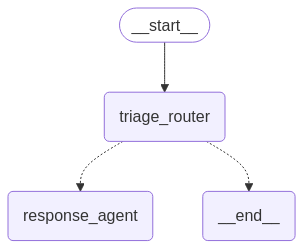

In [31]:
# Show the agent
display(Image(email_agent.get_graph(xray=True).draw_mermaid_png()))

In [32]:
email_input = {
    "author": "Marketing Team <marketing@amazingdeals.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "🔥 EXCLUSIVE OFFER: Limited Time Discount on Developer Tools! 🔥",
    "email_thread": """Dear Valued Developer,

Don't miss out on this INCREDIBLE opportunity!

🚀 For a LIMITED TIME ONLY, get 80% OFF on our Premium Developer Suite!

✨ FEATURES:
- Revolutionary AI-powered code completion
- Cloud-based development environment
- 24/7 customer support
- And much more!

💰 Regular Price: $999/month
🎉 YOUR SPECIAL PRICE: Just $199/month!

🕒 Hurry! This offer expires in:
24 HOURS ONLY!

Click here to claim your discount: https://amazingdeals.com/special-offer

Best regards,
Marketing Team
---
To unsubscribe, click here
""",
}

In [33]:
email_agent.invoke({"email_input": email_input})

Category: IGNORE

Reasoning: This is a marketing email advertising a discounted developer tool suite.  It's a mass email, unsolicited, and falls squarely into the category of marketing newsletters that are not worth John's time to respond to.  He's a senior software engineer, and while such tools might be of interest, this particular email is generic marketing and lacks any information requiring his attention.

result is - 
📧 Classification: RESPOND - This email requires a response


> Entering new AgentExecutor chain...


ValueError: Missing some input keys: {'input'}

In [ ]:
email_input = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

response = email_agent.invoke({"email_input": email_input})
